# Time Series Prediction

**Objectives**
 1. Build a linear, DNN and CNN model in Keras.
 2. Build a simple RNN model and a multi-layer RNN model in Keras.
 
In this lab we will with a linear, DNN and CNN model 

Since the features of our model are sequential in nature, we'll next look at how to build various RNN models in Keras. We'll start with a simple RNN model and then see how to create a multi-layer RNN in Keras.

We will be exploring a lot of different model types in this notebook.


In [1]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1

tensorflow==2.1.0


## Load necessary libraries and set up environment variables

In [2]:
PROJECT = "ml-practice-260405"
BUCKET = "bucket-ml-practice-260405"
REGION = "us-central1"
SAC = 'jupyter-notebook-sac-f'
SAC_KEY_DESTINATION = '/media/mujahid7292/Data/Gcloud_Tem_SAC'

In [3]:
%env
PROJECT = PROJECT
BUCKET = BUCKET
REGION = REGION
SAC = SAC
SAC_KEY_DESTINATION = SAC_KEY_DESTINATION

# Set Google Application Credentials

In [4]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='{}/{}.json'.format(SAC_KEY_DESTINATION,SAC)

Check Whether Google Application Credential Was Set Successfully Outside Virtual Environment

In [5]:
%%bash
set | grep GOOGLE_APPLICATION_CREDENTIALS 

GOOGLE_APPLICATION_CREDENTIALS=/media/mujahid7292/Data/Gcloud_Tem_SAC/jupyter-notebook-sac-f.json


In [6]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from google.cloud import bigquery
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
        DenseFeatures, Conv1D, MaxPool1D, Reshape, RNN,
        LSTM, GRU, Bidirectional)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For reproducible results.
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## Explore time series data

We'll start by pulling a small sample of the time series data from Big Query and write some helper functions to clean up the data for modeling. We'll use the data from the `percent_change_sp500` table in BigQuery. The `close_values_prior_260` column contains the close values for any given stock for the previous 260 days. 

In [7]:
%%time
bq = bigquery.Client(project=PROJECT)

bq_query = """
#standardSQL
SELECT
    symbol,
    Date,
    direction,
    close_value_prior_260
FROM
  `stock_market.eps_percent_change_sp500`
LIMIT
  100
"""

CPU times: user 0 ns, sys: 3.4 ms, total: 3.4 ms
Wall time: 121 ms


The function `clean_data` below does three things:
 1. First, we'll remove any inf or NA values
 2. Next, we parse the `Date` field to read it as a string.
 3. Lastly, we convert the label `direction` into a numeric quantity, mapping 'DOWN' to 0, 'STAY' to 1 and 'UP' to 2. 

In [8]:
def clean_data(input_df):
    """Cleans data to prepare for training.

    Args:
        input_df: Pandas dataframe.
    Returns:
        Pandas dataframe.
    """
    df = input_df.copy()
    
    # Remove inf/na values.
    real_valued_rows = ~(df == np.inf).max(axis=1)
    df = df[real_valued_rows].dropna()

    # TF doesn't accept datetimes in DataFrame.
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # TF requires numeric label.
    df['direction_numeric'] = df['direction'].apply(lambda x: {'DOWN': 0,
                                                               'STAY': 1,
                                                               'UP': 2}[x])
    return df

## Read data and preprocessing

Before we begin modeling, we'll preprocess our features by scaling to the z-score. This will ensure that the range of the feature values being fed to the model are comparable and should help with convergence during gradient descent.

## Read data and preprocessing

Before we begin modeling, we'll preprocess our features by scaling to the z-score. This will ensure that the range of the feature values being fed to the model are comparable and should help with convergence during gradient descent.

In [9]:
STOCK_HISTORY_COLUMN = 'close_values_prior_260'
COL_NAMES = ['day_' + str(day) for day in range(0, 260)]
LABEL = 'direction_numeric'

In [10]:
STOCK_HISTORY_COLUMN = 'close_values_prior_260'
COL_NAMES = ['day_' + str(day) for day in range(0, 260)]
LABEL = 'direction_numeric'

In [11]:
def _scale_features(df):
    """z-scale feature columns of Pandas dataframe.

    Args:
        features: Pandas dataframe.
    Returns:
        Pandas dataframe with each column standardized
        according to the values in that column.
    """
    avg = df.mean()
    std = df.std()
    return (df - avg) / std


def create_features(df, label_name):
    """Create modeling features and label from Pandas
    dataframe.

    Args:
        df: Pandas dataframe.
        label_name: str, the column name of the label.
    Returns:
        Pandas dataframe
    """
    # Expand 1 column containing a list of close prices to 260 columns.
    time_series_features = df[STOCK_HISTORY_COLUMN].apply(pd.Series)

    # Rename columns.
    time_series_features.columns = COL_NAMES
    time_series_features = _scale_features(time_series_features)

    # Concat time series features with static features and label.
    label_column = df[LABEL]

    return pd.concat([time_series_features,
                      label_column], axis=1)

### Make train-eval-test split

Next, we'll make repeatable splits for our train/validation/test datasets and save these datasets to local csv files. The query below will take a subsample of the entire dataset and then create a 70-15-15 split for the train/validation/test sets. 

In [12]:
def _create_split(phase):
    """Create string to produce train/valid/test splits 
    for a SQL query.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
    Returns:
        String.
    """
    floor, ceiling = '2002-11-01', '2010-07-01'
    if phase == 'VALID':
        floor, ceiling = '2010-07-01', '2011-09-01'
    elif phase == 'TEST':
        floor, ceiling = '2011-09-01', '2012-11-30'
    return '''
    WHERE Date >= '{0}'
    AND Date < '{1}'
    '''.format(floor, ceiling)


def create_query(phase):
    """Create SQL query to create train/valid/test splits on 
    subsample.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
        sample_size: str, amount of data to take for subsample.
    Returns:
        String.
    """
    basequery = """
    #standardSQL
    SELECT
      symbol,
      Date,
      direction,
      close_values_prior_260
    FROM
      `stock_market.eps_percent_change_sp500`
    """
    
    return basequery + _create_split(phase)

## Modeling

For experimentation purposes, we'll train various models using data we can fit in memory using the `.csv` files we created above. 

In [13]:
N_TIME_STEPS = 260
N_LABELS = 3

Xtrain = pd.read_csv('stock-train.csv')
Xvalid = pd.read_csv('stock-valid.csv')

ytrain = Xtrain.pop(LABEL)
yvalid  = Xvalid.pop(LABEL)

ytrain_categorical = to_categorical(ytrain.values)
yvalid_categorical = to_categorical(yvalid.values)

To monitor training progress and compare evaluation metrics for different models, we'll use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [14]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

### Baseline

Before we begin modeling in Keras, let's create a benchmark using a simple heuristic. Let's see what kind of accuracy we would get on the validation set if we predict the majority class of the training set. 

In [15]:
sum(yvalid == ytrain.value_counts().idxmax()) / yvalid.shape[0]

0.29490392648287383

Ok. So just naively guessing the most common outcome `UP` will give about 29.5% accuracy on the validation set. 

### Linear model

We'll start with a simple linear model, mapping our sequential input to a single fully dense layer. 

In [ ]:
model = Sequential()

model.add(
    Dense(
        units=N_LABELS,
        activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l1(l=0.1)
    )
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history = model.fit(
    x=Xtrain.values,
    y=ytrain_categorical,
    batch_size=Xtrain.shape[0],
    validation_data=(Xvalid.values, yvalid_categorical),
    epochs=30,
    verbose=0
)

In [ ]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

In [ ]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

The accuracy seems to level out pretty quickly. To report the accuracy, we'll average the accuracy on the validation set across the last few epochs of training.

In [ ]:
np.mean(history.history['val_accuracy'][-5:])

### Deep Neural Network

The linear model is an improvement on our naive benchmark. Perhaps we can do better with a more complicated model. Next, we'll create a deep neural network with Keras. We'll experiment with a two layer DNN here but feel free to try a more complex model or add any other additional techniques to try an improve your performance. 

In [17]:
dnn_hidden_units = [16, 8]

model = Sequential()

for layer in dnn_hidden_units:
    model.add(
        Dense(
            units=layer,
            activation="relu"
        )
    )
    
model.add(
    Dense(
        units=N_LABELS,
        activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l1(l=0.1)
    )
)

model.compile(
    optimizer=Adam(lr=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x=Xtrain.values,
    y=ytrain_categorical,
    batch_size=Xtrain.shape[0],
    validation_data=(Xvalid.values, yvalid_categorical),
    epochs=10,
    verbose=0
)

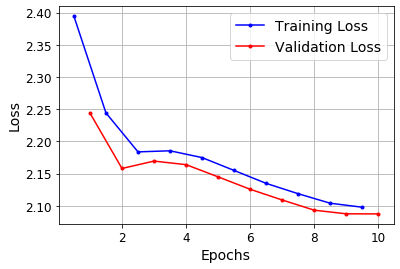

In [18]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

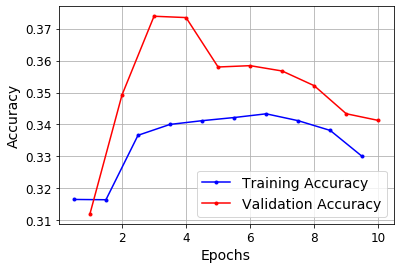

In [19]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [20]:
np.mean(history.history['val_accuracy'][-5:])

0.35037595